In [115]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from scipy.stats import zscore


# Load Data


In [116]:
df = pd.read_csv('calories_burn.csv')
df

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190,94,29,105,40.8,231
1,14861698,female,20,166,60,14,94,40.3,66
2,11179863,male,69,179,79,5,88,38.7,26
3,16180408,female,34,179,71,13,100,40.5,71
4,17771927,female,27,154,58,10,81,39.8,35
...,...,...,...,...,...,...,...,...,...
14995,15644082,female,20,193,86,11,92,40.4,45
14996,17212577,female,27,165,65,6,85,39.2,23
14997,17271188,female,43,159,58,16,90,40.1,75
14998,18643037,male,78,193,97,2,84,38.3,11


In [117]:
df.columns

Index(['User_ID', 'Gender', 'Age', 'Height', 'Weight', 'Duration',
       'Heart_Rate', 'Body_Temp', 'Calories'],
      dtype='object')

# Data UnderStanding

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  int64  
 4   Weight      15000 non-null  int64  
 5   Duration    15000 non-null  int64  
 6   Heart_Rate  15000 non-null  int64  
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 1.0+ MB


In [119]:
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [120]:
df.isnull().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [121]:
df.duplicated().sum()   

np.int64(0)

In [122]:
df.dtypes

User_ID         int64
Gender         object
Age             int64
Height          int64
Weight          int64
Duration        int64
Heart_Rate      int64
Body_Temp     float64
Calories        int64
dtype: object

In [123]:
df.shape

(15000, 9)

# Check The Outliers $ Skweness

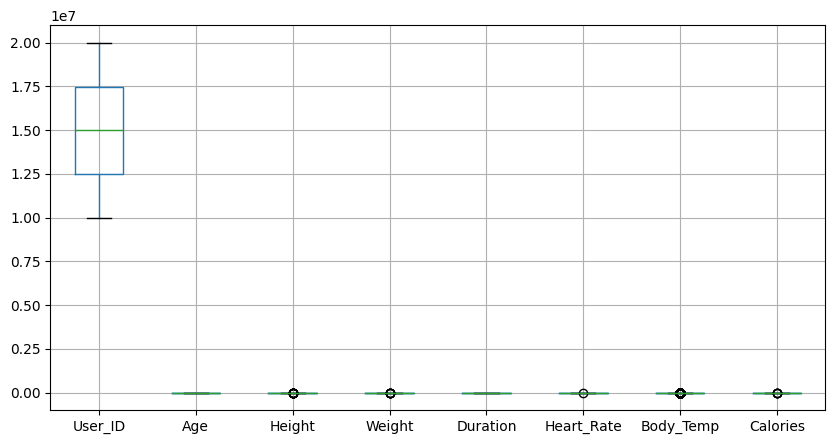

In [124]:
df.boxplot(figsize=(10, 5))
plt.show()

In [125]:
numerical_cols = df.select_dtypes(include=['int64', 'float64'])

skewness = numerical_cols.skew()
print(skewness)


User_ID       0.004788
Age           0.473383
Height       -0.006190
Weight        0.226725
Duration      0.004751
Heart_Rate   -0.010704
Body_Temp    -0.994382
Calories      0.505371
dtype: float64


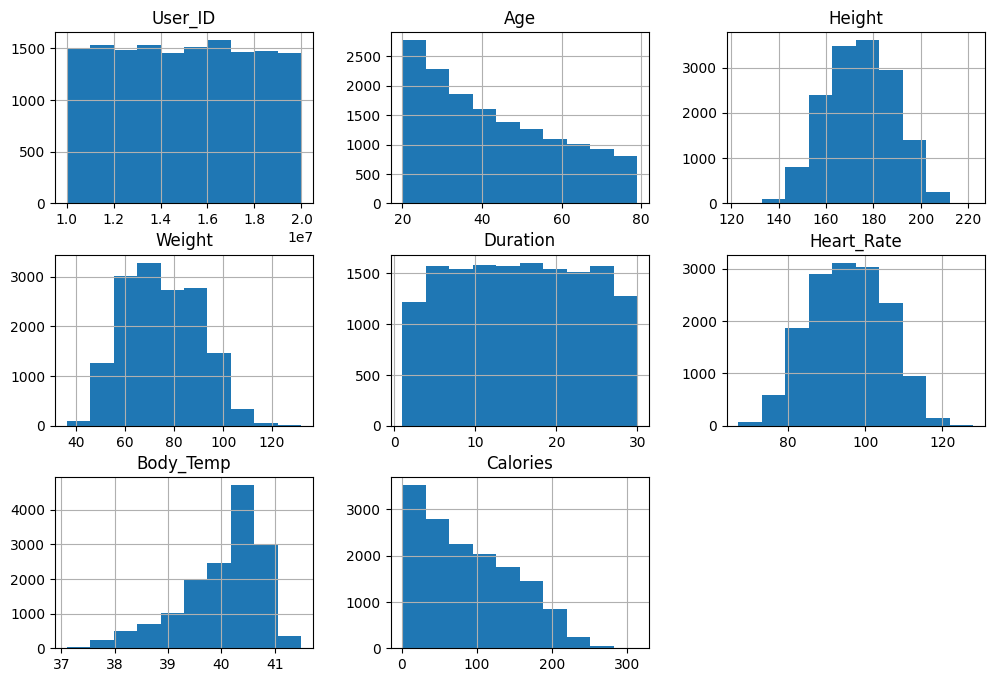

In [126]:
df.hist(figsize=(12, 8))
plt.show()

# Data Preprocessing & Scaling

In [127]:
skewness = {
    "User_ID": 0.004788,
    "Age": 0.473383,
    "Height": -0.006190,
    "Weight": 0.226725,
    "Duration": 0.004751,
    "Heart_Rate": -0.010704,
    "Body_Temp": -0.994382,
    "Calories": 0.505371
}

def remove_outliers(df, col, method="iqr"):
    if method == "iqr":
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    elif method == "zscore":
        df = df[np.abs(zscore(df[col])) < 3]
    return df

for col, skew in skewness.items():
    if col != "Calories":  
        if abs(skew) > 0.5:
            df = remove_outliers(df, col, method="iqr")
        elif 0.3 < abs(skew) <= 0.5:
            df = remove_outliers(df, col, method="zscore")

In [128]:
df.drop(columns=['User_ID'], inplace=True)

In [129]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  


scaled_features = scaler.fit_transform(df[['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']])

scaled_df = pd.DataFrame(scaled_features, columns=['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'])

print(scaled_df.head())

        Age    Height    Weight  Duration  Heart_Rate  Body_Temp
0  1.482122  1.090293  1.266138  1.616552    0.970269   1.023978
1 -1.343690 -0.593955 -0.996149 -0.232475   -0.198511   0.310938
2  1.540993  0.318346  0.268071 -1.341892   -0.836028  -1.970789
3 -0.519495  0.318346 -0.264232 -0.355744    0.439005   0.596154
4 -0.931592 -1.436080 -1.129224 -0.725549   -1.579798  -0.402101


# Model Training 

In [130]:
X = df[['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']]  
y = df['Calories']  

In [131]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [133]:
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [134]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

LinearRegression()

In [136]:
# Set the number of iterations to test with different random_state values
n = 50
random_state = []
r2_scores = []
mae_scores = []
mse_scores = []
rmse_scores = []
mape_scores = []

# Loop through to test the model with different random_state values
for i in range(n):
    random_state.append(i)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    # Train Linear Regression model
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)
    
    # Make predictions
    y_pred = linear_regressor.predict(X_test)
    
    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Append results
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

# Print average scores
print(f"Average R²: {np.mean(r2_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average MSE: {np.mean(mse_scores)}")



Average R²: 0.9666345624073907
Average MAE: 8.3393272892245
Average MSE: 127.21552573006622


# Save The Model

In [139]:
joblib.dump(linear_regressor, 'linear_regressor_model.pkl')


['linear_regressor_model.pkl']